In [1]:
from osgeo import gdal
import fiona
import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio as rio

from nansat import Nansat
from nansat import *

from s1denoise import Sentinel1Image
from s1denoise import *

import matplotlib.pyplot as plt
%matplotlib inline

import scipy
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.datasets import make_classification
from sklearn import preprocessing

import matplotlib as mpl

In [2]:
# Define path locations
s1_st_path = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20210716T054037_20210716T054102_027815_0351B0_E546.zip'
s1_nt_path = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20210707T171707_20210707T171732_027691_034E02_704A.zip'
s1_2015 = '/container_dir1/subsets/S1A_IW_GRDH_1SDV_20150728T170854_20150728T170919_007014_009866_9AF5.zip'
s1_nt_path_feb = '/container_dir1/subsets/S1A_IW_GRDH_1SDV_20210228T054121_20210228T054146_036786_045321_D2D0.zip'
s1_nt_path_march = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20210309T171702_20210309T171727_025941_031822_64A6.zip'
s1_nt_path_april = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20210426T171703_20210426T171728_026641_032E79_0FDD.zip'
s1_nt_path_may = '/container_dir1/subsets/S1A_IW_GRDH_1SDV_20210511T054123_20210511T054148_037836_047737_812E.zip'
s1_nt_path_june = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20210625T171706_20210625T171731_027516_0348DE_41ED.zip'
s1_nt_path_july = '/container_dir1/subsets/S1A_IW_GRDH_1SDV_20210722T054127_20210722T054152_038886_0496AA_8C3D.zip'
s1_nt_path_aug = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20210807T170858_20210807T170923_028143_035B7B_52BE.zip'
s1_nt_path_sep = '/container_dir1/subsets/S1A_IW_GRDH_1SDV_20210908T054130_20210908T054155_039586_04ADDC_EE10.zip'
s1_nt_path_oct = '/container_dir1/subsets/S1A_IW_GRDH_1SDV_20211017T171741_20211017T171806_040162_04C1B1_C588.zip'
s1_nt_path_nov = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20211116T171711_20211116T171736_029616_0388CC_3723.zip'
s1_nt_path_dec = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20211217T170849_20211217T170914_030068_039713_1E1E.zip'
s2_path = '/container_dir1/subsets/Subset_S2_20210716_resampled.tif'
src_awei = '/container_dir1/subsets/AWEI_S2B_MSIL2A_20210716.tif'
src_ndwi = '/container_dir1/subsets/NDWI_S2B_MSIL2A_20210716.tif'
src_vis = '/container_dir1/subsets/VIs_Subset_S2B_MSIL2A_20210716.tif'

In [110]:
# Open files
s1_july_early = Nansat(s1_nt_path)

04:25:31|40|nansat|_get_dataset_metadata|GDAL could not open /container_dir1/subsets/S1B_IW_GRDH_1SDV_20210707T171707_20210707T171732_027691_034E02_704A.zip, trying to read with Nansat mappers...


In [3]:
# Open all Sentinel-1 pictures to stack them and plot the median of the year of both VV and VH backscatter
s1_feb = Nansat(s1_nt_path_feb)
s1_march = Nansat(s1_nt_path_march)
s1_april = Nansat(s1_nt_path_april)
s1_may = Nansat(s1_nt_path_may)
s1_june = Nansat(s1_nt_path_june)
s1_july = Nansat(s1_nt_path_july)
s1_aug = Nansat(s1_nt_path_aug)
s1_sep = Nansat(s1_nt_path_sep)
# s1_oct = ... # those pictures all have the NaNs in them
s1_nov = Nansat(s1_nt_path_nov)
s1_dec = Nansat(s1_nt_path_dec)

02:51:48|40|nansat|_get_dataset_metadata|GDAL could not open /container_dir1/subsets/S1A_IW_GRDH_1SDV_20210228T054121_20210228T054146_036786_045321_D2D0.zip, trying to read with Nansat mappers...
02:52:07|40|nansat|_get_dataset_metadata|GDAL could not open /container_dir1/subsets/S1B_IW_GRDH_1SDV_20210309T171702_20210309T171727_025941_031822_64A6.zip, trying to read with Nansat mappers...
02:52:24|40|nansat|_get_dataset_metadata|GDAL could not open /container_dir1/subsets/S1B_IW_GRDH_1SDV_20210426T171703_20210426T171728_026641_032E79_0FDD.zip, trying to read with Nansat mappers...
02:52:41|40|nansat|_get_dataset_metadata|GDAL could not open /container_dir1/subsets/S1A_IW_GRDH_1SDV_20210511T054123_20210511T054148_037836_047737_812E.zip, trying to read with Nansat mappers...
02:53:01|40|nansat|_get_dataset_metadata|GDAL could not open /container_dir1/subsets/S1B_IW_GRDH_1SDV_20210625T171706_20210625T171731_027516_0348DE_41ED.zip, trying to read with Nansat mappers...
02:53:18|40|nansat|_

In [4]:
# Reproject the data to Sentinel-2, so the visualisation is similar

s1 = [s1_feb, s1_march, s1_april, s1_may, s1_june, s1_july, s1_aug, s1_sep, s1_nov, s1_dec]
n = gdal.Open(s2_path)
d = Domain(ds=n)

for i in s1:
    i.reproject(d)

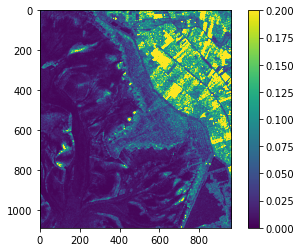

In [70]:
plt.imshow(s1[0][10], vmin=0, vmax=0.2);plt.colorbar()
# plotting that took 10 minutes...

In [10]:
VV_feb = s1[0][10]
# assigning all at once in a loop or what also takes literal hours
# assigning one takes 10 min

In [12]:
VV_march = s1[1][10]

In [26]:
VV_april = s1[2][10]
VV_may = s1[3][10]
VV_june = s1[4][10]

In [27]:
VV_july= s1[5][10]
VV_aug = s1[6][10]
VV_sep = s1[7][10]
VV_nov = s1[8][10]
VV_dec = s1[9][10]
# took 30 min

In [28]:
VV = [VV_feb, VV_march, VV_may, VV_june, VV_july, VV_aug, VV_sep, VV_nov, VV_dec]

In [29]:
VV_arr = np.array(VV)

In [30]:
VV_arr.shape

(9, 1091, 960)

In [5]:
VH_feb = s1[0][8]
VH_march = s1[1][8]
VH_april = s1[2][8]

In [6]:
VH_may = s1[3][8]
VH_june = s1[4][8]

In [9]:
VH_july= s1[5][8]
VH_aug = s1[6][8]
VH_sep = s1[7][8]

In [8]:
VH_nov = s1[8][8]
VH_dec = s1[9][8]

In [13]:
VH = [VH_feb, VH_march, VH_may, VH_june, VH_july, VH_aug, VH_sep, VH_nov, VH_dec]
VH_arr = np.array(VH)

In [31]:
VV_medn = np.median(VV_arr, axis=0)
VH_medn = np.median(VH_arr, axis=0)

VV_mean = np.mean(VV_arr, axis=0)
VH_mean = np.mean(VH_arr, axis=0)

VV_std = np.std(VV_arr, axis=0)
VH_std = np.std(VH_arr, axis=0)

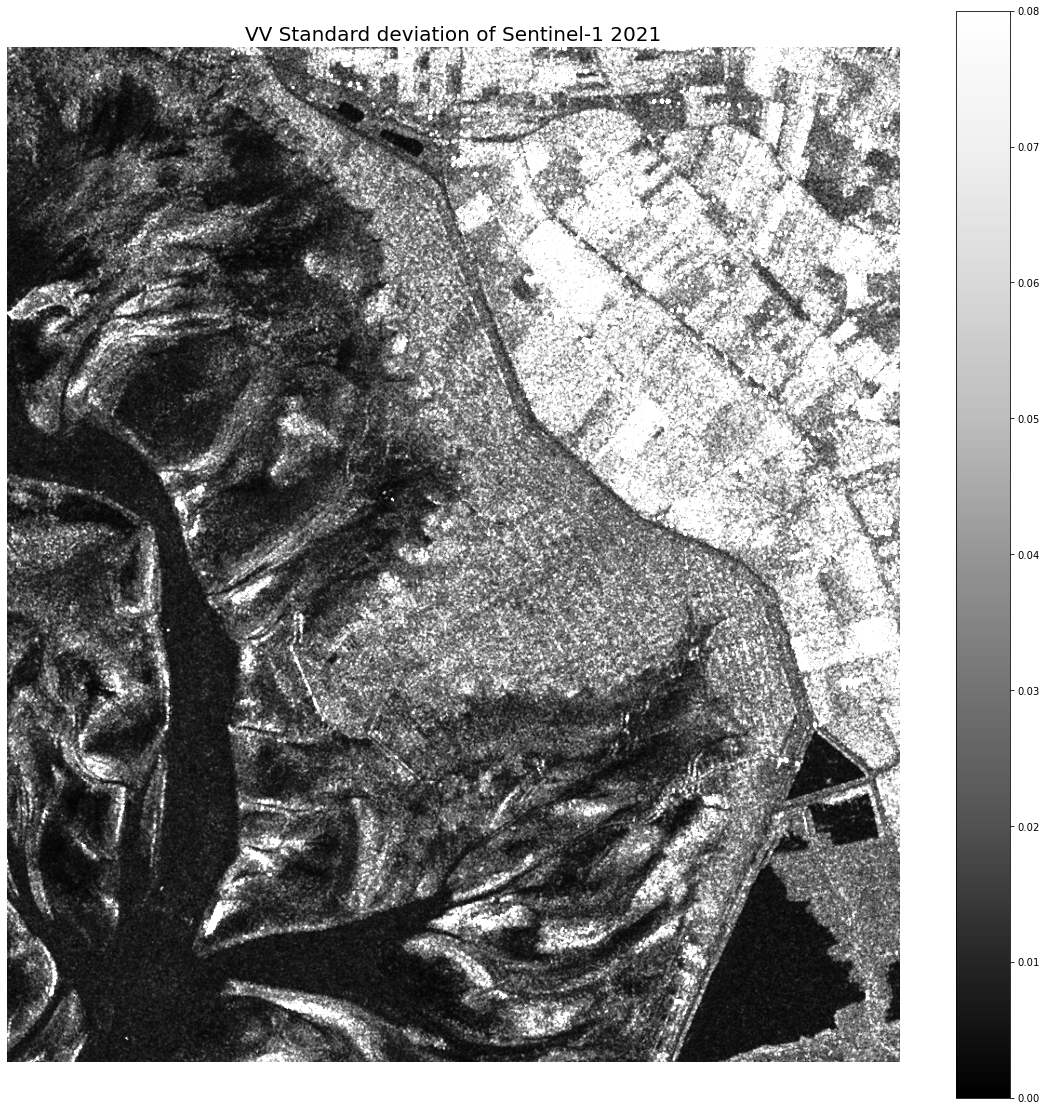

In [113]:
#plt.imshow(medn, vmin=0, vmax=0.4);plt.colorbar()

# Plotting the different descriptive statistics of the Sentinel-1 time series pictures to check for anything crazy
# And as we can see, the Standard deviation is somewhat weird. There should only be deviation on the edges of the saltmarsh, because there the vegetation changes the most throughout the year, but there is still
# a lot happening in the saltmarsh. This could be bad for the classification. Also the edges of the tidal creek are problematic.

fig = plt.figure(figsize=(20,20))
fig.add_subplot(1, 1, 1)
plt.axis("off")
plt.imshow(VV_std, vmin=0, vmax=0.08, cmap='Greys_r'), plt.colorbar()
plt.title('VV Standard deviation of Sentinel-1 2021', fontsize=20)
plt.savefig('VV_sd_Sentinel1_TimeSeries_bw_2.png')

In [ ]:
# VV =[s1[0][10], s1[1][10], s1[2][10], s1[3][10], s1[4][10], s1[5][10], s1[6][10], s1[7][10], s1[8][10], s1[9][10]]
# this takes forever, literally, after 1400 seconds I had to restart the kernel.
# other methods like .append also take that long

In [13]:
ndwi = Nansat(src_ndwi)
awei = Nansat(src_awei)
raw_bands_s2 = Nansat(s2_path)
vis = Nansat(src_vis)

In [111]:
#Reproject the S1 data to S2
s1r = s1_july_early
n = gdal.Open(s2_path)
d = Domain(ds=n)
s1r.reproject(d)

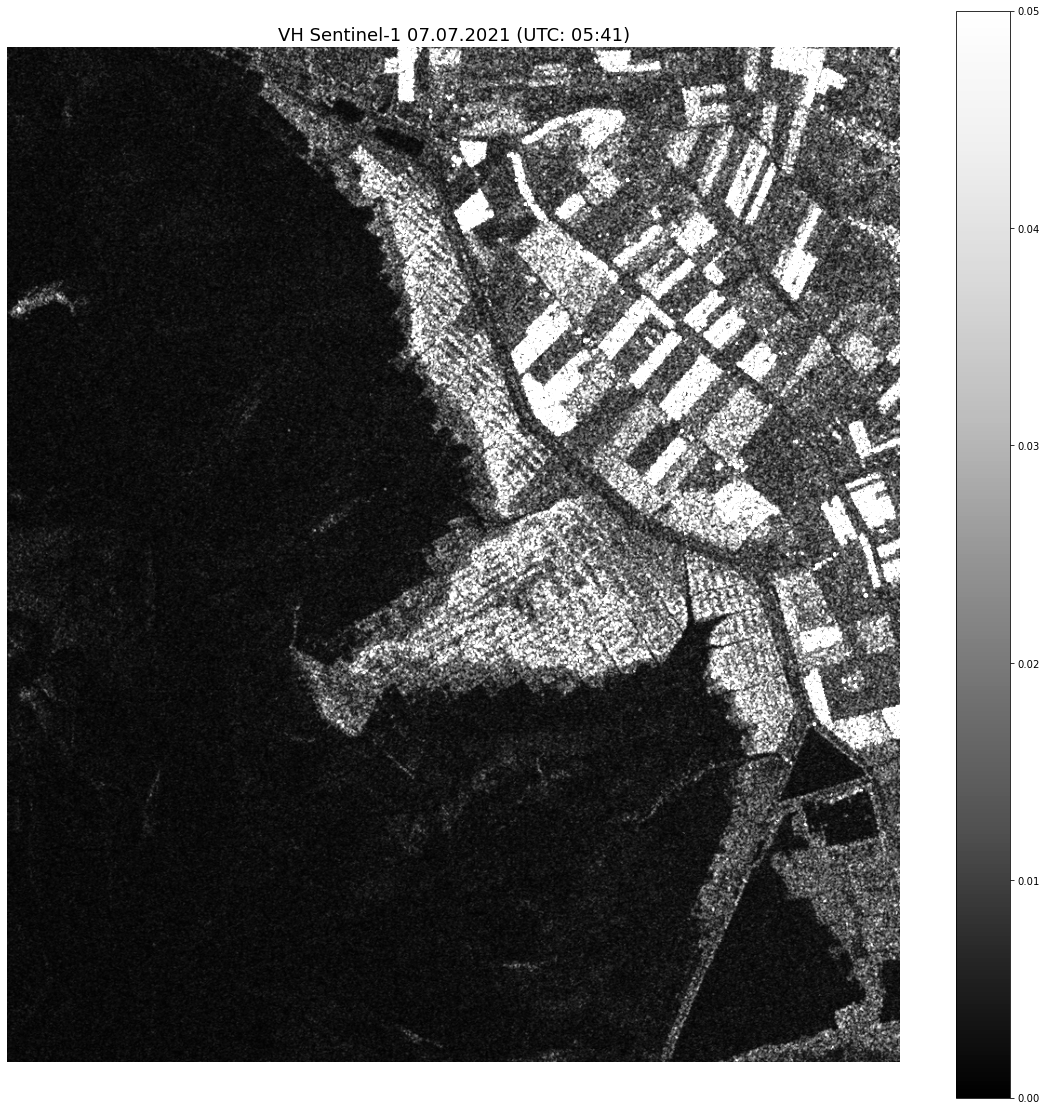

In [122]:
fig = plt.figure(figsize=(20,20))
fig.add_subplot(1, 1, 1)
plt.imshow(s1r[8], vmin=0, vmax=0.05, cmap='Greys_r');plt.colorbar()
plt.axis('off')
plt.title('VH Sentinel-1 07.07.2021 (UTC: 05:41)', fontsize=18)
plt.savefig('fig_vh.png')

In [43]:
#Reproject the S1 data to S2
s1r = s1
n = gdal.Open(s2_path)
d = Domain(ds=n)
s1r.reproject(d)

In [15]:
# Stack as multi-dimensional np array (or more first as list and then convert to array)
all_bands = [raw_bands_s2[band_n] for band_n in raw_bands_s2.bands().keys()]
all_bands.append(ndwi[1])
all_bands.append(awei[1])
for band_n in vis.bands().keys():
    all_bands.append(vis[band_n])

In [16]:
all_bands.append(s1r[8])

In [17]:
all_bands.append(s1r[10])

In [18]:
bands_stack = np.array(all_bands)

# Check the shape of the array, should have 15 layers - 6 optical bands, 7 indices and 2 SAR-bands
bands_stack.shape

(15, 1091, 960)

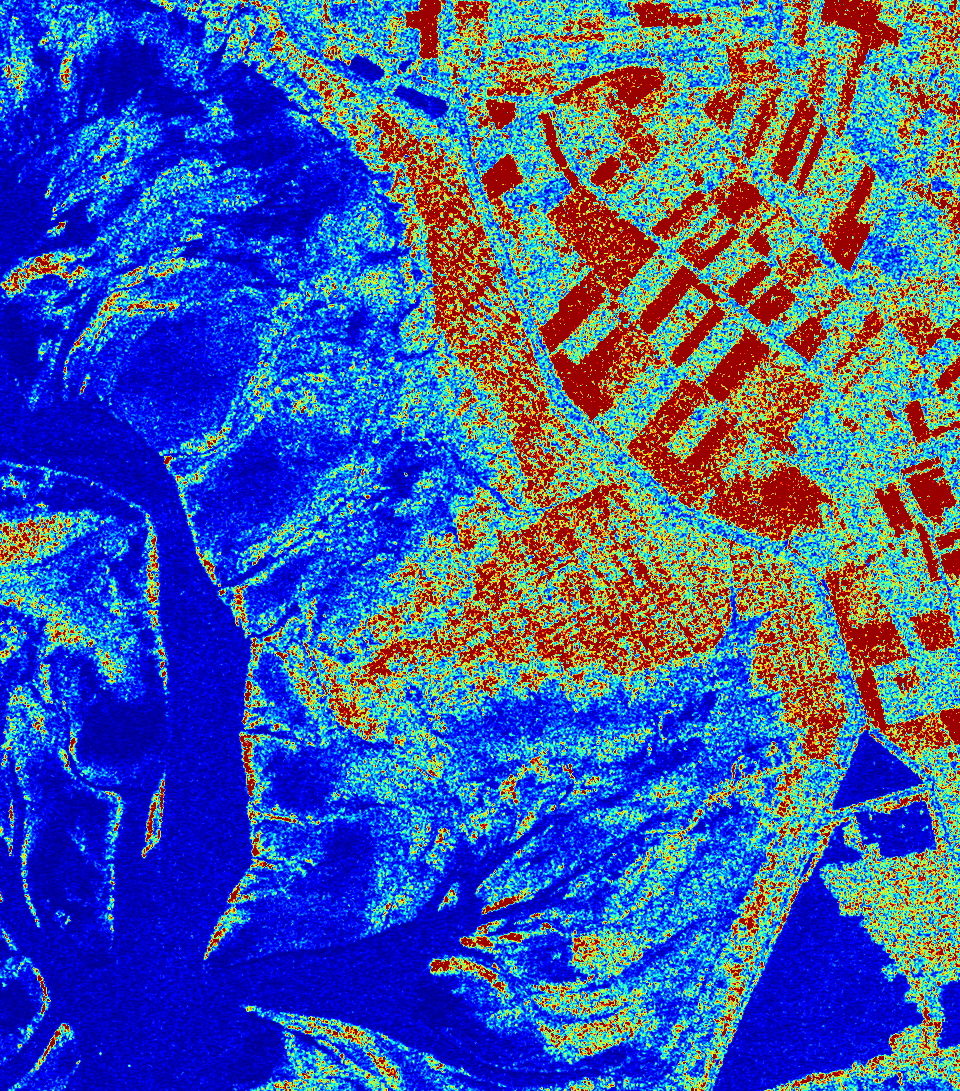

In [51]:
from IPython.display import Image
# define re-coloring in a look-up-table (LUT)
# LUT is a dictionray:
#     key   - pixel value in the mask
#     value - RGB code for the result
#mask_lut = {1 : [128,128,128],
#            2 : [255,255,255]}

# write RGB and use the mask to change color of the black corners and land
s1r.write_figure(filename="test.png", bands=[10, 8], vmin=0, vmax=0.2) # clim='hist') #mask_array=mask_array)
 #                         
#               mask_lut=mask_lut)
Image(filename='test.png')

In [53]:
with rio.open('/container_dir1/results/all_bands_masked.tif') as src:
    s1_stack = src.read()

VV = s1r[10]
VH = s1r[8]
VV_VH = VV/VH

Text(0.5, 1.0, 'VH-Image of Sentinel-1 on 07.07.2021 (05:41 UTC)')

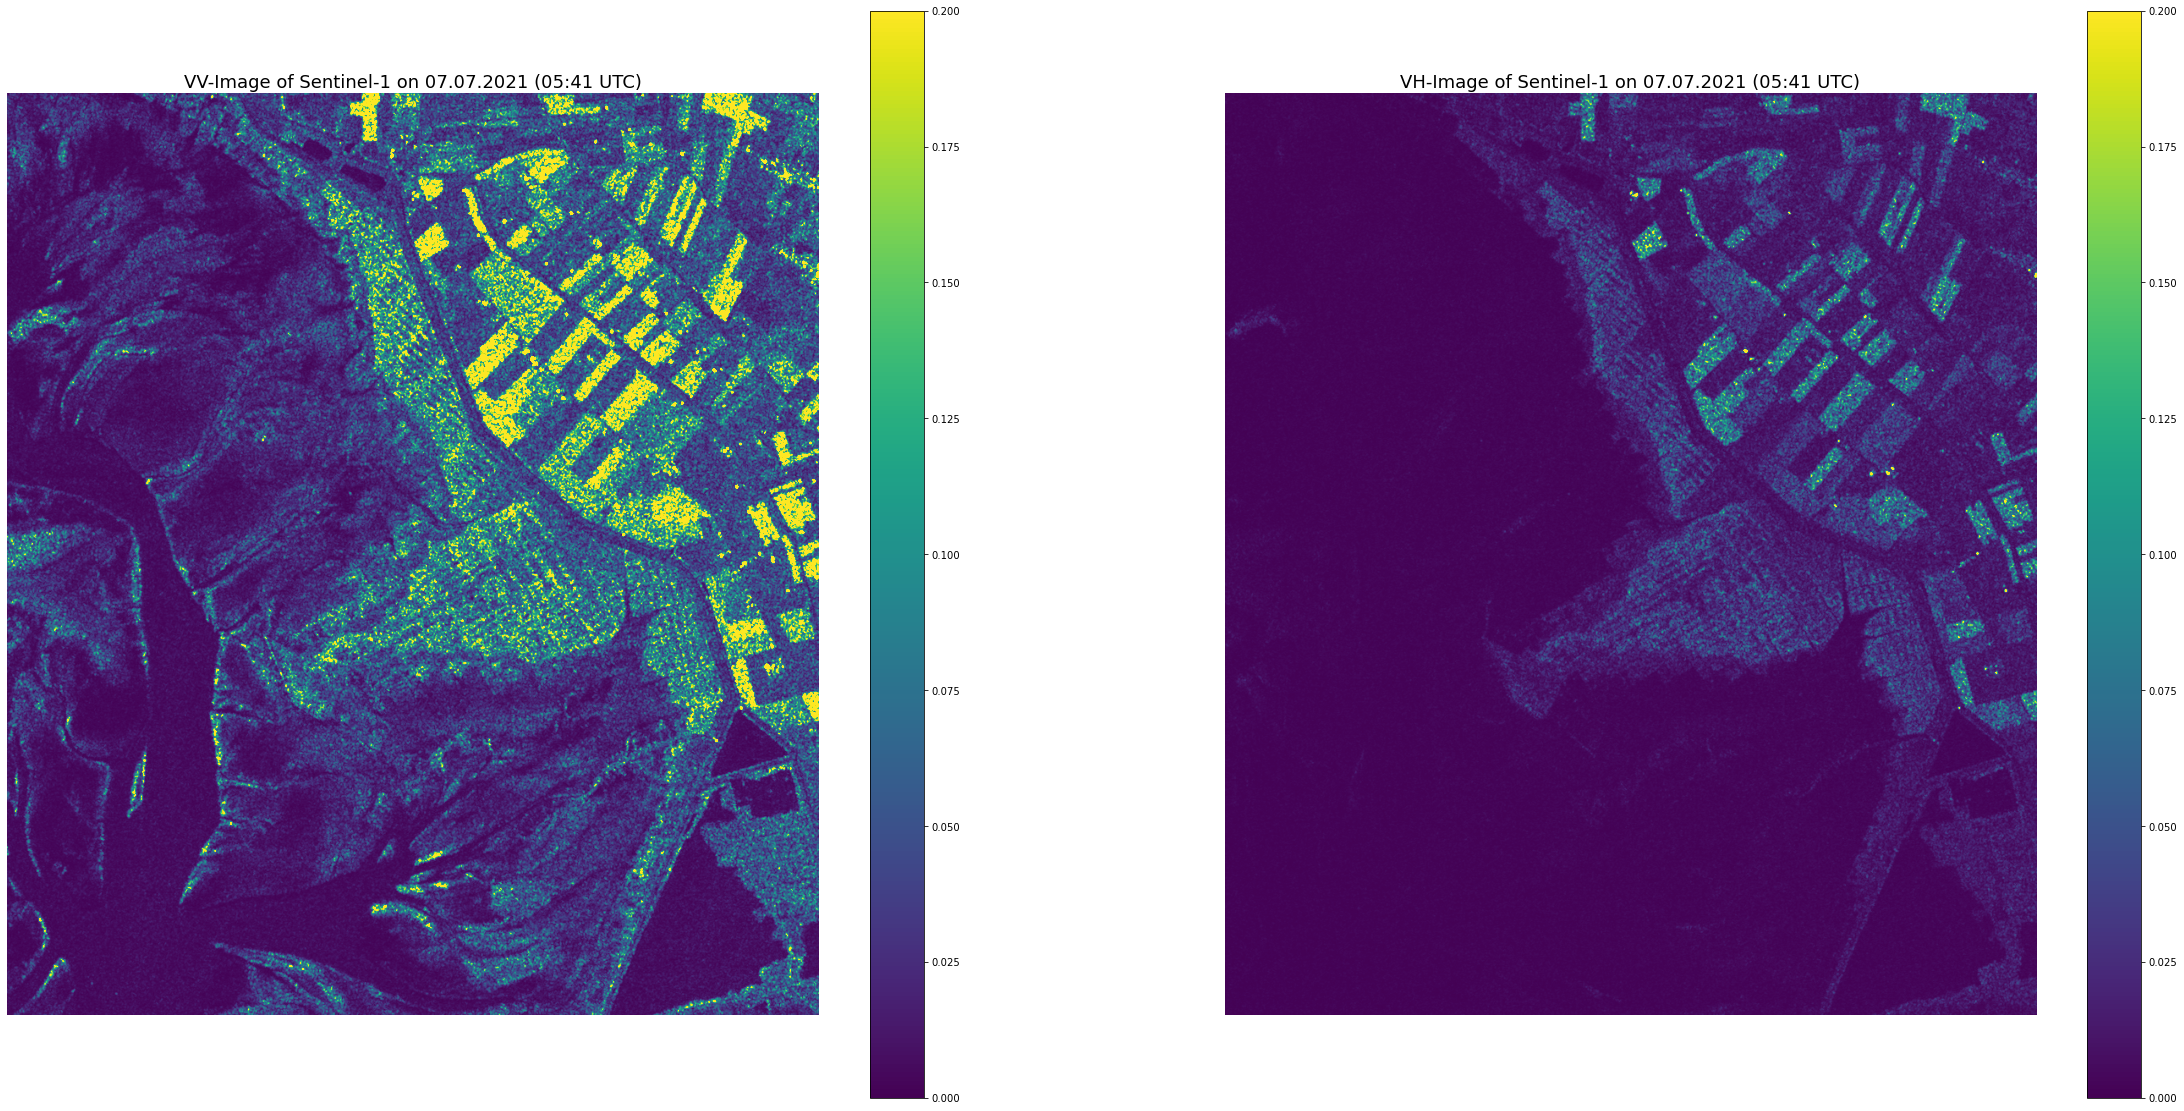

In [67]:
fig = plt.figure(figsize=(40,20))
fig.add_subplot(1, 2, 1)
plt.axis("off")
plt.imshow(VV, vmin=0, vmax=0.2), plt.colorbar()
plt.title('VV-Image of Sentinel-1 on 07.07.2021 (05:41 UTC)', fontsize=18)

fig.add_subplot(1, 2, 2)
plt.axis("off")
plt.imshow(VH, vmin=0, vmax=0.2), plt.colorbar()
plt.title('VH-Image of Sentinel-1 on 07.07.2021 (05:41 UTC)', fontsize=18)

#plt.savefig('S1_cividis.png')

In [90]:
type(s1_stack)

numpy.ndarray

In [365]:
VV = s1_stack[14]
VH = s1_stack[13]

# create array for mask with zeros only
mask_array_vv = np.zeros(VV.shape)
mask_array_vh = np.zeros(VH.shape)

mask_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [366]:
# in the mask, change values to -1 where VV is below 0.025 (water)
mask_array_vv[VV < 0.025] = -1   
mask_array_vh[VH < 0.02] = -1

mask_array_vv

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ...,  0.,  0., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

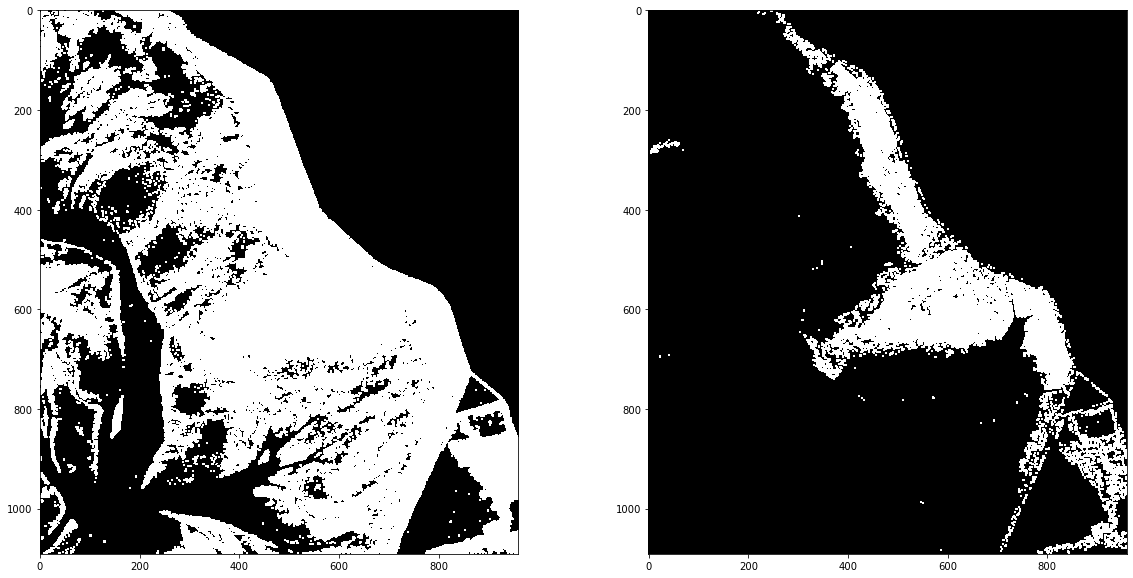

In [367]:
# in the mask, change values to  where VH is below 0.18 (water)
mask_array_vv[mask_array_vv == 0] = np.nan 
mask_array_vh[mask_array_vh == 0] = np.nan
# show mask
fig = plt.figure(figsize=(20,10))  
fig.add_subplot(1, 2, 1)
plt.imshow(mask_array_vv, cmap='gray')

fig.add_subplot(1, 2, 2)
plt.imshow(mask_array_vh, cmap='gray')
#plt.show()

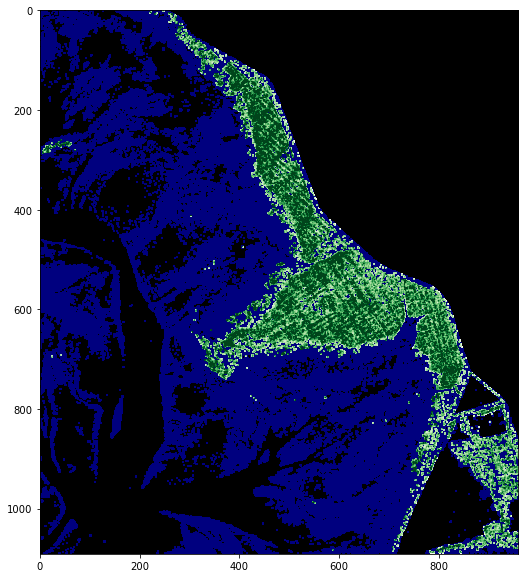

In [368]:
fig = plt.figure(figsize=(20,10))
plt.imshow(VV, vmin=0, vmax=0.1, cmap='Greens')
plt.imshow(mask_array_vh, cmap='jet')
plt.imshow(mask_array_vv, cmap='gray')

In [103]:
points2.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich